In [1]:
#!/usr/bin/env python

# Plot_Idealized-MCS-tracking-examples.ipynb

In [2]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
# import ESMF
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
# import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys 
import matplotlib.gridspec as gridspec
import seaborn
# from mpl_toolkits.basemap import Basemap, cm
import xarray as xr
import geopandas as gpd
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from Tracking_Functions import calc_grid_distance_area, ObjectCharacteristics

def distance(origin, destination):
    lat1, lon1 = origin
    lat2, lon2 = destination
    radius = 6371 # km

    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km


###  USER INPUT SECTION

In [3]:
trackers = ['Andreas', 'Julia','Amanda', 'TAMS', 'Zhe','TOOCAN']
track_name = ['prein', 'kukulies','Rehbein', 'TAMS', 'feng','TOOCAN']
tracker_names = ['MOAAP', 'tobac','ForTraCC', 'TAMS', 'PyFLEXTRKR','TOOCAN']


mask_name = ['MCS_objects', 'segmentation_mask','mcs_mask', 'MCS_objects', 'MCS_objects','MCS_label']
tr_colors = ['#1f78b4','#33a02c','#e31a1c','#ff7f00','#a6cee3','#cab2d6']

datadir = '/glade/campaign/mmm/c3we/prein/Papers/2022-SA-MCS-Tracking/data/Idealized_cases/'
case = '1_3-merging_1-splitting_Prein_tracking_Smooth'

### Read the precipitation and Tb data

In [8]:
ncid = Dataset('/glade/u/home/prein/papers/2022-SA-MCS-Tracking/programs/Ideal_MCSs_cases/MCS-test-1_3-merging_1-splitting.nc', mode='r')
Lat = np.squeeze(ncid.variables['lat'][:])
Lon = np.squeeze(ncid.variables['lon'][:])
tb = np.squeeze(ncid.variables['Tb'][:])
pr = np.squeeze(ncid.variables['PR'][:])
ncid.close()
_,_,Area,Gridspacing = calc_grid_distance_area(Lat,Lon)

# read in the masks from the different trackers
mcs_mask = np.zeros((tb.shape[0], tb.shape[1], tb.shape[2], len(trackers)))
mcs_stats = {}
for tr in tqdm(range(len(trackers))):
    files = np.sort(glob.glob(datadir + case + '/' + trackers[tr] + '/*.nc'))
    if len(files) == 1:
        ncid = Dataset(files[0], mode='r')
        mcs_mask[:,:,:,tr] = np.squeeze(ncid.variables[mask_name[tr]][:])
        ncid.close()
    else:
        for fi in range(len(files)):
            ncid = Dataset(files[fi], mode='r')
            mask = np.squeeze(ncid.variables[mask_name[tr]][:])
            mcs_mask[fi,:,:,tr] = mask
            ncid.close()
    
    mcs_stats[trackers[tr]] = ObjectCharacteristics(mcs_mask[:,:,:,tr].astype(int), # feature object file
                         tb,         # original file used for feature detection
                         './Track-results/'+trackers[tr]+'_'+case+'.pkl',        # output file name and locaiton
                         np.array(range(mcs_mask.shape[0])).astype(int),            # timesteps of the data
                         Lat,             # 2D latidudes
                         Lon,             # 2D Longitudes
                         Gridspacing,     # average grid spacing
                         Area,
                         MinTime=1,       # minimum lifetime of an object
                         Boundary = 1)   # 1 --> remove object when it hits the boundary of the domain

 50%|█████     | 3/6 [00:00<00:00, 12.48it/s]

            Loop over 1 objects
            Loop over 2 objects
            Loop over 1 objects
            Loop over 1 objects
            Loop over 3 objects


100%|██████████| 6/6 [00:01<00:00,  5.21it/s]

            Loop over 3 objects


### Plot the data on a map

mkdir: cannot create directory ‘’: No such file or directory


        Plot map to: 1_3-merging_1-splitting_Prein_tracking_Smooth.pdf


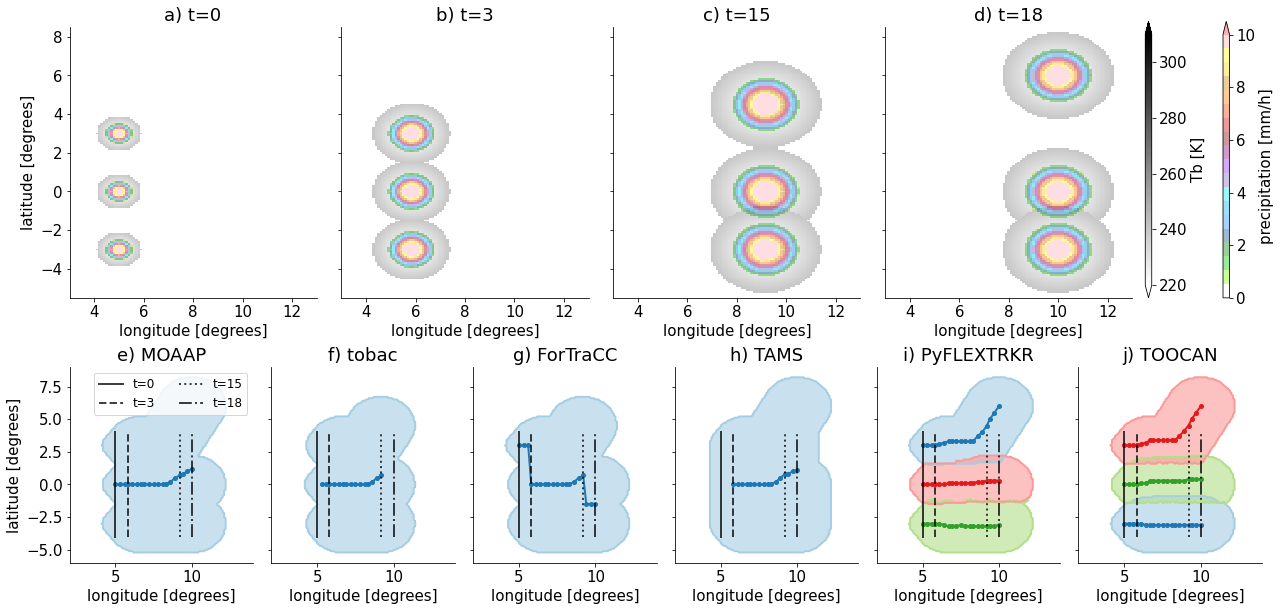

In [13]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

import seaborn as sns
from scipy.stats import kde
import cartopy.feature as cfeature
rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')

rgsLableABC=list(string.ascii_lowercase)+list(string.ascii_uppercase)

fig = plt.figure(figsize=(18,8))
import seaborn as sns
plt.rcParams.update({'font.size': 15})
# Histogram plots
gs1 = gridspec.GridSpec(1,4) #rgiSize[2])
gs1.update(left=0.06, right=0.88,
           bottom=0.5, top=0.97,
           wspace=0.1, hspace=0.05)

# Plot the MCS Origin in Stage IV and CONUS404
proj = ccrs.PlateCarree() #ccrs.Robinson() 

# --------------------------------
# Plot precipitation from IMERG and WRF
COLORS = ["#ffffff", "#7fff00", "#00cd00", "#008b00", "#104e8b",
   "#1e90ff", "#00b2ee", "#00eeee", "#8968cd", "#912cee",
   "#8b008b", "#8b0000", "#cd0000", "#ee4000", "#ff7f00",
   "#cd8500", "#ffd700", "#ffff00", "#ffaeb9"]
# LEVS     = np.array([0., 0.01, 0.1, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0,
#    2.5, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 60.0])
# LEVS     = np.array([0., 0.01, 0.1, 0.25, 0.50, 0.75, 1.0, 1.25, 1.50, 1.75, 2.0,
#    2.5, 3.0, 4.0, 5.0, 7.0, 10.0, 15.0, 20.0, 60.0])
cmap = matplotlib.colors.ListedColormap(COLORS)


# ax.set_extent((-70, -50, -45, -30), ccrs.PlateCarree())

tb[tb > 241] = np.nan
pr_nan = pr
pr_nan[pr_nan < 0.5] = np.nan

ii = 0
for tt in [0,3,18-3,18]:
    ax = plt.subplot(gs1[0,ii])
#     plt.axis('off')
    plt.title(rgsLableABC[ii]+') t='+str(tt))
    
    # PLOT TB
    cs_tb = ax.pcolormesh(Lon, Lat, tb[tt,:,:], cmap='gray_r', vmin=220, vmax=310, alpha=1)
    # PLOT PRECIPITATION
    cs_pr = ax.pcolormesh(Lon, Lat, pr_nan[tt,:,:], cmap=cmap, vmin=0, vmax=10, alpha=0.4)
    
    plt.xlim((3,13))
    plt.ylim((-5.5,8.5))
    if ii == 0:
        ax.set_ylabel('latitude [degrees]')
    else:
        plt.tick_params(labelleft = False)
    ax.set_xlabel('longitude [degrees]')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ii += 1

CbarAx = axes([0.89, 0.5, 0.005, 0.48])
cb = colorbar(cs_tb, cax = CbarAx, orientation='vertical', extend='both') #, ticks=LEVS)
cb.set_label('Tb [K]') #, fontsize=12)
    
CbarAx = axes([0.95, 0.5, 0.005, 0.48])
cb = colorbar(cs_pr, cax = CbarAx, orientation='vertical', extend='max') #, ticks=LEVS)
cb.set_label('precipitation [mm/h]') #, fontsize=12)


    

# PLOT TRACKS SEPERATELY
gs1 = gridspec.GridSpec(1,len(trackers))
gs1.update(left=0.06, right=0.98,
           bottom=0.04, top=0.38,
           wspace=0.1, hspace=0.05)

lon_track = mcs_stats[trackers[0]][str(1)]['rgrMassCentLatLon'][:,0]
lat_track = mcs_stats[trackers[0]][str(1)]['rgrMassCentLatLon'][:,1]

# PLOT MCS TRACKS
key_times = [0,3,15,18]
line_styles = ['-','--',':','-.']
mcs_colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00']
for tr in range(len(trackers)):
    ax = plt.subplot(gs1[0, tr])
#     plt.axis('off')
    
    ind_tmp = mcs_stats[trackers[tr]]
    for ii in range(len(ind_tmp)):
        jj  = list(mcs_stats[trackers[tr]].keys())[ii]
        # plot outline of each MCS
#         for tt in range(mcs_mask.shape[0])[::2]:
        mcs_footprint = np.sum(mcs_mask[:,:,:,tr] == int(jj), axis=0) > 0
        mcs_footprint[mcs_footprint == 0] == np.nan
        ax.contourf(Lon, Lat, mcs_footprint, 
                levels = (0.9,1.1), colors = mcs_colors[ii*2], alpha=0.6)
        ax.contour(Lon, Lat, mcs_footprint, 
                levels = (0.9,1.1), colors = mcs_colors[ii*2], linewidths=2, zlevel = 10)
    
        # plot track
        ax.plot(mcs_stats[trackers[tr]][str(jj)]['rgrMassCentLatLon'][:,0], mcs_stats[trackers[tr]][str(jj)]['rgrMassCentLatLon'][:,1],
                 c = mcs_colors[ii*2+1], lw=2, ls = '-')
        ax.plot(mcs_stats[trackers[tr]][str(jj)]['rgrMassCentLatLon'][:,0], mcs_stats[trackers[tr]][str(jj)]['rgrMassCentLatLon'][:,1],
                 c = mcs_colors[ii*2+1], marker='o', lw=0, markersize=4)
    
    # add vertical lines for key timesteps
    for vl in range(4):
        plt.plot([lon_track[key_times[vl]],lon_track[key_times[vl]]], 
                 [-4,4], 
                 c='k', ls=line_styles[vl], lw=2, alpha=0.75, 
                 label = 't='+str(key_times[vl]))
    
    
    plt.title(rgsLableABC[tr+4]+') '+tracker_names[tr])
    plt.xlim((2,14))
    plt.ylim((-6,9))
    if tr == 0:
        ax.set_ylabel('latitude [degrees]')
        plt.legend(ncol=2, prop={'size': 12})
    else:
        plt.tick_params(labelleft = False)
    ax.set_xlabel('longitude [degrees]')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
        
sPlotFile=''
sPlotName= case + '.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight') #, dpi=700)
print( '        Plot map to: '+sPlotFile+sPlotName)